<a href="https://colab.research.google.com/github/ShruthiVidya-git/MultimodalContrastiveLearning/blob/main/Gloria-VIT/Inference_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import all the required modules
from google.colab import drive
drive.mount('/content/drive')

import torch, torch.nn as nn, cv2, numpy as np, pickle, os, re, tqdm, random, sys, pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt

sys.path.insert(0,'/content/drive/MyDrive/Summer_Project-ECE_697/src_code/Models/')
import gloria_model
from gloria_model import Gloria

import vit
from vit import VisionTransformer

sys.path.insert(0,'/content/drive/MyDrive/Summer_Project-ECE_697/src_code/Inference/')
import similarities

sys.path.insert(0,'/content/drive/MyDrive/Summer_Project-ECE_697/ConVIRT Pytorch')
from model import ModelCLR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def _get_batch_tensors(df):
    """
    Get batches of image and text tensors
    """
    img_paths = list(df['img_emd'])
    
    img_tensors = []
    paths = []
    for idx in range(len(df)):
        # read batch of 25 image tensors
        with open(img_paths[idx], 'rb') as f:
            img_tensor = pickle.load(f)
        tensor_out = tensor_reshape(img_tensor)

        img_tensors.append(tensor_out)
        paths.append(img_paths[idx].split('/tensor_image/')[1].split('.pickle')[0].replace('_', '/'))
    img = torch.stack(img_tensors).squeeze()

    return img, paths

def tensor_reshape(img_tensor):

    if img_tensor.shape[2] != 256:
        tensor_out = nn.functional.pad(input=img_tensor, pad=(0, 0, 1,0) , mode='constant', value=0)
        return tensor_out

    elif img_tensor.shape[3] != 256:
        tensor_out = nn.functional.pad(input=img_tensor, pad=(0, 1, 0,0) , mode='constant', value=0)
        return tensor_out

    return img_tensor


In [ ]:
# Get the prompt embeddings
embed_captions = "/content/drive/MyDrive/Summer_Project-ECE_697/src_code/checkpoints/captions_local_global_6_classes.pickle"
with open(embed_captions, "rb") as f:
    embed = pickle.load(f)

# get the local global and caption lens of prompts    
text_emb_l = embed['local_embed']
text_emb_g = embed['global_embed']
cap_lens = embed['cap_lens_avg']

In [ ]:
# read csv with 5 classes
data_path = '/content/drive/MyDrive/Summer_Project-ECE_697/src_code/Inference/multi_class_data.csv'
data_5_classes = pd.read_csv(data_path)

In [ ]:
# define the 5 classes for classification
classes = list(data_5_classes.columns)[-5:]

# define the ground truth from csv
class5_temp = data_5_classes.iloc[:,-5:]
ground_truth = []
for i in range(len(class5_temp)):
    a = list(class5_temp.iloc[i])
    b = ''.join(str(i) for i in a)
    ground_truth.append(b)

In [ ]:
y_test = []
for i in range(len(class5_temp)):
    a = list(class5_temp.iloc[i])
    y_test.append(np.argmax(a))

## MultiClass Classification Results

Gloria Multiclass Classification Results

In [ ]:
checkpoints = '/content/drive/MyDrive/Summer_Project-ECE_697/src_code/checkpoints/model.pt'
# get the weights from the most recent checkpoint
model_gloria = Gloria()
checkpoint = torch.load(checkpoints)
model_gloria.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
# get a test data
img, paths = _get_batch_tensors(data_5_classes)
model_out = model_gloria.get_local_global_features(img)

img_g = model_out[0]
img_l = model_out[1]

In [ ]:
# ger the predictions of 5 classes from Gloria model
simi = []
y_pred = []
for idx in range(len(img_g)):
    sim = []
    for cls in classes:
        img_emb_l = img_l[idx].unsqueeze(0)
        text_emb_l =  embed['local_embed'][cls].unsqueeze(0)
        cap_lens = embed['cap_lens_avg'][cls]
        img_emb_g = img_g[idx].unsqueeze(0)
        text_emb_g = embed['global_embed'][cls].unsqueeze(0)

        sim.append( similarities.get_similarities(img_emb_g, text_emb_g, img_emb_l, text_emb_l, cap_lens) )
    id = np.argmax(sim)
    a = [1 if i==id else 0 for i in range(len(classes))]
    y_pred.append(np.argmax(a))
    simi.append(b)

In [ ]:
pos = 0
true_idx = []
for i in range(len(ground_truth)):
    if y_pred[i] == y_test[i]:
        pos += 1
        true_idx.append(i)

acc= pos/len(ground_truth)*100
print(f"Accuracy of the multi-class {acc}%")

Accuracy of the multi-class 43.29896907216495%


In [ ]:
matrix = confusion_matrix(y_test, y_pred)
class_acc = matrix.diagonal()/matrix.sum(axis=1)*100
for i,cls in enumerate(classes):
    print(f"Accuracy of {cls} is {class_acc[i]}%")

Accuracy of Atelectasis is 45.0%
Accuracy of Cardiomegaly is 75.0%
Accuracy of Consolidation is 18.181818181818183%
Accuracy of Edema is 26.31578947368421%
Accuracy of Pleural Effusion is 26.31578947368421%


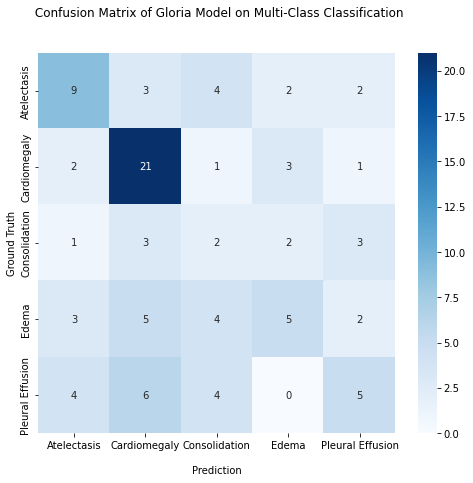

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
ax = sns.heatmap(matrix, annot=True, cmap='Blues')

ax.set_title(' Confusion Matrix of Gloria Model on Multi-Class Classification\n\n');
ax.set_xlabel('\nPrediction')
ax.set_ylabel('Ground Truth');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=classes))

                  precision    recall  f1-score   support

     Atelectasis       0.47      0.45      0.46        20
    Cardiomegaly       0.55      0.75      0.64        28
   Consolidation       0.13      0.18      0.15        11
           Edema       0.42      0.26      0.32        19
Pleural Effusion       0.38      0.26      0.31        19

        accuracy                           0.43        97
       macro avg       0.39      0.38      0.38        97
    weighted avg       0.43      0.43      0.42        97



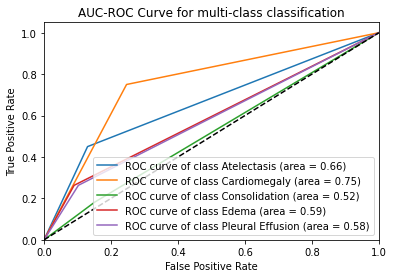

In [ ]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    a = [id == i for id in y_test]
    y_test_i = [1 if x == True else 0 for x in a]

    a = [id == i for id in y_pred]
    y_pred_i = [1 if x == True else 0 for x in a]
    
    fpr[i], tpr[i], _ = roc_curve(y_test_i, y_pred_i)
    roc_auc[i] = auc(fpr[i], tpr[i])

for i,c in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(c, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve for multi-class classification')
plt.legend(loc="lower right")
plt.show()

Multi Class results for VIT and BERT Model

In [ ]:
checkpoints_vit = '/content/drive/MyDrive/Summer_Project-ECE_697/src_code/checkpoints/model_vit.pt'
model_vit = VisionTransformer()
vit_checkpoint = torch.load(checkpoints_vit)
model_vit.load_state_dict(vit_checkpoint['model_state_dict'])


<All keys matched successfully>

In [ ]:
# get encoded vector by passing through the model 
vit_img = model_vit.encode(img)

In [ ]:
#and the similarities

simi_vit = []
y_pred_vit = []
for idx in range(len(img_g)):
    sim = []
    for cls in classes:
        text_emb_g = embed['global_embed'][cls].unsqueeze(0)
        sim.append( similarities.get_global_similarities(vit_img[idx].unsqueeze(0), text_emb_g) )

    id = np.argmax(sim)
    a = [1 if i==id else 0 for i in range(len(classes))]
    y_pred_vit.append(np.argmax(a))
    simi_vit.append(b)


In [ ]:
pos = 0
true_idx = []
for i in range(len(ground_truth)):
    if y_pred_vit[i] == y_test[i]:
        pos += 1
        true_idx.append(i)

acc_vit= pos/len(ground_truth)*100
print(f"Accuracy of the multi-class {acc_vit}%")

Accuracy of the multi-class 26.804123711340207%


In [ ]:
print(classification_report(y_test, y_pred_vit, target_names=classes))

                  precision    recall  f1-score   support

     Atelectasis       0.20      0.05      0.08        20
    Cardiomegaly       0.36      0.18      0.24        28
   Consolidation       0.11      0.18      0.13        11
           Edema       0.31      0.58      0.41        19
Pleural Effusion       0.29      0.37      0.33        19

        accuracy                           0.27        97
       macro avg       0.25      0.27      0.24        97
    weighted avg       0.27      0.27      0.24        97



In [ ]:
matrix = confusion_matrix(y_test, y_pred_vit)
class_acc = matrix.diagonal()/matrix.sum(axis=1)*100
for i,cls in enumerate(classes):
    print(f"Accuracy of {cls} is {class_acc[i]}%")

Accuracy of Atelectasis is 5.0%
Accuracy of Cardiomegaly is 17.857142857142858%
Accuracy of Consolidation is 18.181818181818183%
Accuracy of Edema is 57.89473684210527%
Accuracy of Pleural Effusion is 36.84210526315789%


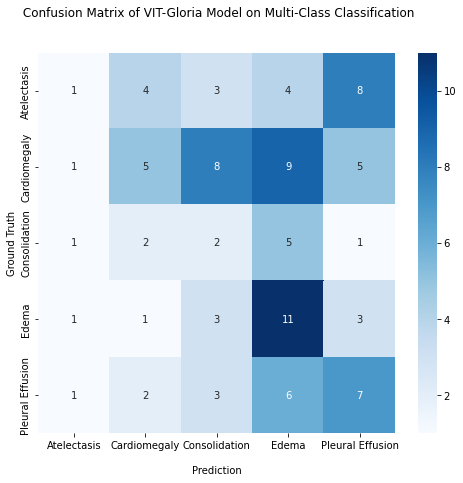

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
ax = sns.heatmap(matrix, annot=True, cmap='Blues')

ax.set_title(' Confusion Matrix of VIT-Gloria Model on Multi-Class Classification\n\n');
ax.set_xlabel('\nPrediction')
ax.set_ylabel('Ground Truth');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.
plt.show()

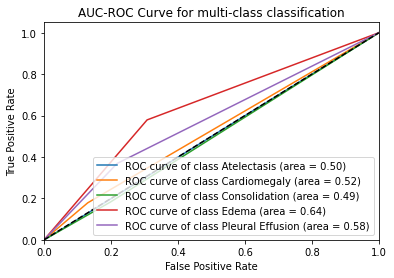

In [ ]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    a = [id == i for id in y_test]
    y_test_i = [1 if x == True else 0 for x in a]

    a = [id == i for id in y_pred_vit]
    y_pred_vit_i = [1 if x == True else 0 for x in a]
    
    fpr[i], tpr[i], _ = roc_curve(y_test_i, y_pred_vit_i)
    roc_auc[i] = auc(fpr[i], tpr[i])

for i,c in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(c, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve for multi-class classification')
plt.legend(loc="lower right")
plt.show()

## Binary Classification Results

Get global and local prompt embeddings for Pneumonia

In [ ]:
text_emb_l = embed['local_embed']['Pneumonia']
text_emb_g = embed['global_embed']['Pneumonia']
cap_lens = embed['cap_lens_avg']['Pneumonia']

Import the binary classification dataset

In [ ]:
binary_csv = '/content/drive/MyDrive/Summer_Project-ECE_697/src_code/Inference/Bin_class_data.csv'
binary_classification_df = pd.read_csv(binary_csv)
ground_truth = list(binary_classification_df['Pneumonia'])

Import Gloria Model and the latest checkpoint for loading the trained model weights

In [ ]:
checkpoints = '/content/drive/MyDrive/Summer_Project-ECE_697/src_code/checkpoints/model.pt'
# get the weights from the most recent checkpoint
model_gloria = Gloria()
checkpoint = torch.load(checkpoints)
model_gloria.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Read the input files and pass through the trained model to get the embeddings

In [ ]:
# get a test data embeddings

img, paths = _get_batch_tensors(binary_classification_df)
model_out = model_gloria.get_local_global_features(img)

img_g = model_out[0]
img_l = model_out[1]

Get the similarity scores and threashold is set at 1 for ikdentifying the presence of Pneumonia

In [ ]:
sim = []
for idx in range(len(img_g)):
    sim.append( similarities.get_similarities(img_g[idx].unsqueeze(0), text_emb_g.unsqueeze(0), img_l[idx].unsqueeze(0), text_emb_l.unsqueeze(0), cap_lens) )

threshold = 0.7
similarity = [int(sim[i]>threshold) for  i in range(len(sim))]

In [ ]:
pos = 0
for i in range(len(sim)):
    if similarity[i] == ground_truth[i]:
        pos += 1
acc = (pos/len(similarity))*100
print('Accuracy of Gloria Model for Binary Classification : ', acc,'%')

Accuracy of Gloria Model for Binary Classification :  68.66666666666667 %


In [ ]:
cf_matrix = confusion_matrix(ground_truth, similarity)

print(cf_matrix)

[[ 95  55]
 [ 39 111]]


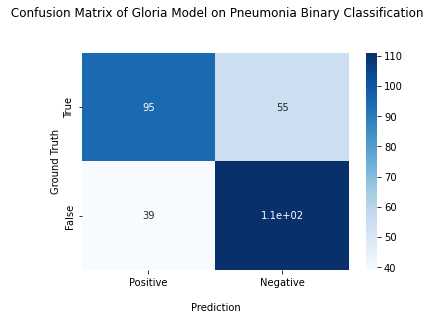

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title(' Confusion Matrix of Gloria Model on Pneumonia Binary Classification\n\n');
ax.set_xlabel('\nPrediction')
ax.set_ylabel('Ground Truth');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['True','False'])

## Display the visualization of the Confusion Matrix.
plt.show()

Repeat the same process for VIT Model to get the accuracy of the binary classification task

In [ ]:
checkpoints_vit = '/content/drive/MyDrive/Summer_Project-ECE_697/src_code/checkpoints/model_vit.pt'
model_vit = VisionTransformer()
vit_checkpoint = torch.load(checkpoints_vit)
model_vit.load_state_dict(vit_checkpoint['model_state_dict'])

vit_img = model_vit.encode(img)

In [ ]:
sim_vit = []
for idx in range(len(vit_img)):
    sim_vit.append( similarities.get_global_similarities(vit_img[idx].unsqueeze(0), text_emb_g.unsqueeze(0)) )

threshold = -0.008
similarity_vit = [int(sim_vit[i]>threshold) for  i in range(len(sim_vit))]

In [ ]:
pos_vit = 0
for i in range(len(sim_vit)):
    if similarity_vit[i] == ground_truth[i]:
        pos_vit += 1
acc_vit = (pos_vit/len(similarity_vit))*100
print('Accuracy of VIT Model for Binary Classification : ', acc_vit,'%')

Accuracy of VIT Model for Binary Classification :  46.33333333333333 %


In [ ]:
cf_matrix = confusion_matrix(ground_truth, similarity_vit)

print(cf_matrix)

[[59 91]
 [70 80]]


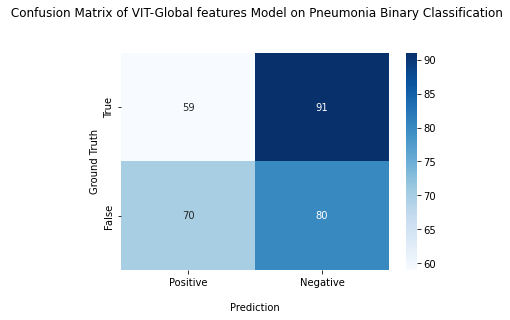

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title(' Confusion Matrix of VIT-Global features Model on Pneumonia Binary Classification\n\n');
ax.set_xlabel('\nPrediction')
ax.set_ylabel('Ground Truth');

ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['True','False'])

plt.show()